In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt
import time

In [2]:
def load_data(data_dir, img_size=(128, 128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace('.jpg', '_mask.jpg'))
    
            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
    
            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
    
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
# 데이터 로드
train_dir = '/kaggle/input/unet12345/split_datasets/train'
val_dir = '/kaggle/input/unet12345/split_datasets/val'
test_dir = '/kaggle/input/unet12345/split_datasets/test'

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

In [4]:
# 모델 정의

# DepthWise Sepearable Convolution 함수
def depthwise_separable_conv(x, pointwise_filters, stride=1):
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

# Channel Shuffling 기법
class ChannelShuffle(layers.Layer):
    def __init__(self, groups, **kwargs):
        super(ChannelShuffle, self).__init__(**kwargs)
        self.groups = groups

    def call(self, x):
        batch_size, height, width, num_channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, (batch_size, height, width, self.groups, num_channels // self.groups))
        x = tf.transpose(x, perm=[0, 1, 2, 4, 3])
        x = tf.reshape(x, (batch_size, height, width, num_channels))
        return x

def shufflenet_block(x, out_channels, stride=1, groups=2):
    if x.shape[-1] % groups != 0:
        padding_channels = groups - (x.shape[-1] % groups)
        x = layers.Conv2D(x.shape[-1] + padding_channels, kernel_size=1, padding='same')(x)

    x = layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False, groups=groups)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_separable_conv(x, out_channels)
    x = ChannelShuffle(groups)(x)

    return x

def build_shufflenet_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    conv1 = shufflenet_block(inputs, 32)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = shufflenet_block(pool1, 64)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = shufflenet_block(pool2, 128)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = shufflenet_block(pool3, 256)

    up7 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4)
    up7 = layers.concatenate([up7, conv3])
    conv7 = shufflenet_block(up7, 128)

    up8 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = shufflenet_block(up8, 64)

    up9 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = shufflenet_block(up9, 32)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
model = build_shufflenet_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 4)    │             16 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │             64 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 128, 128, 32)   │            288 │ re_lu[0][0]            │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          1,024 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ channel_shuffle           │ (None, 128, 128, 32)   │              0 │ re_lu_2[0][0]          │
│ (ChannelShuffle)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ channel_shuffle[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │          1,024 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 338,705 (1.29 MB)

 Trainable params: 334,481 (1.28 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [6]:
# 손실 함수 및 지표 정의
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    dice_loss_value = dice_loss(y_true, y_pred)
    return a * dice_loss_value + (1 - a) * logit_loss_value

In [7]:
model.compile(optimizer='adam',
              loss=combined_loss,
              metrics=[dice_coef])

# 콜백 설정
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.9,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [8]:
# 모델 학습
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, model_checkpoint]
                   )

model.save('baseline_unet_model.keras')

Epoch 1/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - dice_coef: 0.0778 - loss: 0.9024
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - dice_coef: 0.0787 - loss: 0.9013 - val_dice_coef: 1.1786e-10 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.3312 - loss: 0.6466
Epoch 2: val_dice_coef did not improve from 0.00000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - dice_coef: 0.3383 - loss: 0.6398 - val_dice_coef: 1.1786e-10 - val_loss: 0.9742 - learning_rate: 0.0010
Epoch 3/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.6862 - loss: 0.3043
Epoch 3: val_dice_coef did not improve from 0.00000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - dice_coef: 0.6869 - loss: 0.3037 - val_dice_coef: 1.1786e-10 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 4/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.7655 - loss: 0.2271
Epoch 4: ReduceLROnP

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


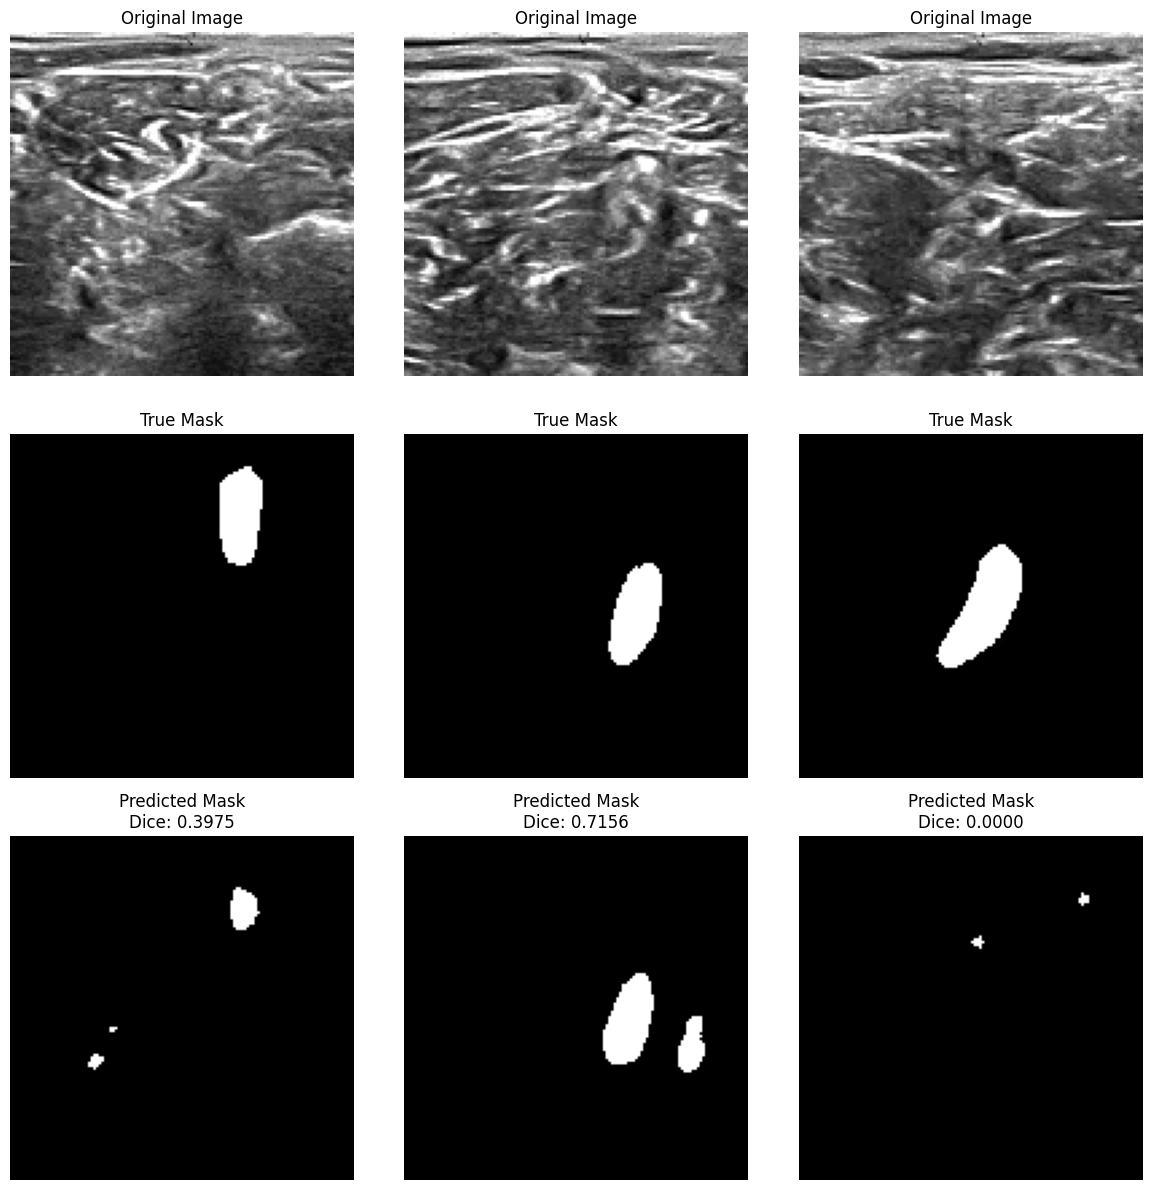

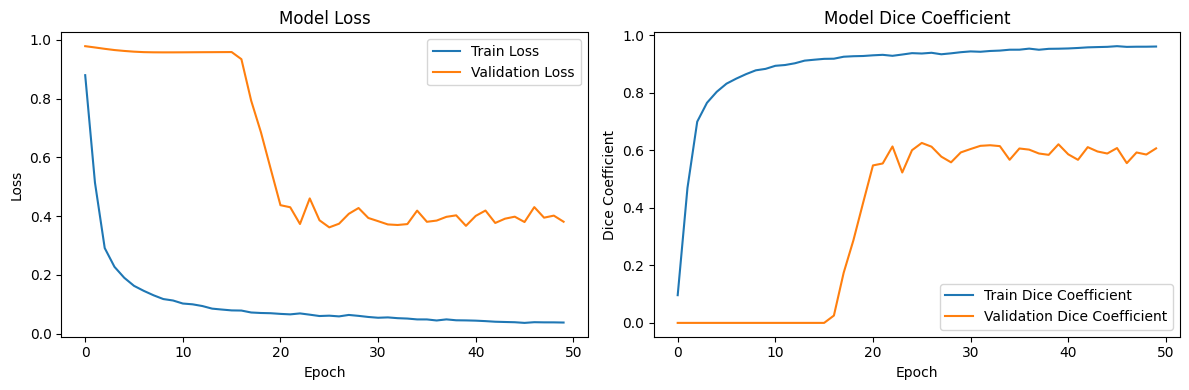

In [9]:
# 시각화 함수
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])
    predictions = (predictions > 0.5).astype(np.float32)
    plt.figure(figsize=(4*num_samples, 12))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title(f'Predicted Mask\nDice: {dice_coef(y[i:i+1], predictions[i:i+1]).numpy():.4f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_results(model, X_test, y_test)

# 손실 및 지표 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [17]:
# 성능 지표 출력 함수
def print_performance_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(np.float32)

    # Dice 계수 계산
    dice_score = dice_coef(y_test, predictions).numpy()
    print(f'Dice Coefficient: {dice_score:.4f}')

    # 모델 크기 계산
    model_size = model.count_params() * 4 / (1024 ** 2)  # float32 가정
    print(f'Model Parameter : {model.count_params()}')
    print(f'Model size: {model_size:.2f} MB')

    # 계산 시간 측정
    start_time = time.time()
    _ = model.predict(X_test)  # 예측을 통해 시간 측정
    elapsed_time = time.time() - start_time
    print(f'Elapsed time for prediction: {elapsed_time:.4f} seconds')

# 성능 지표 출력 호출
print_performance_metrics(model, X_test, y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Dice Coefficient: 0.2466
Model Parameter : 338705
Model size: 1.29 MB
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Elapsed time for prediction: 0.0923 seconds
